# Task 0
Here we import some basic modules, read the data, clean it and split it into training and test sets.

In [1]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
plt.style.use("fivethirtyeight")
warnings.simplefilter(action='ignore', category=FutureWarning)          #some code samples return useless future warnings, this suppresses them

#read data
training = pd.read_csv("data/train_set.csv")
test = pd.read_csv("data/test_set.csv")

#drop useless columns
test.dropna(inplace=True)
test.drop(columns="Unnamed: 0",inplace=True)
training.drop(columns="Unnamed: 0",inplace=True)
training.dropna(inplace=True)                       

In [2]:
#convert all values to numeric while maintatining order so eg a vgood rating will be greater than a good one
subs = [['low','small','unacc','med','acc','big','high','good','vgood','vhigh','more','5more'],[0,0,0,1,1,2,2,2,3,3,5,5]]
training.replace(subs[0],subs[1],inplace=True)
test.replace(subs[0],subs[1],inplace=True)

for col in training.columns:
    training[col] = pd.to_numeric(training[col])
    test[col] = pd.to_numeric(test[col])

In [3]:
#split data into predictors/labels and training/test
predictorCols = ['buying','maint','doors','persons','lug_boot','safety']
X = training[predictorCols]
y = training['rating']
XTest = test[predictorCols]
yTest = test['rating']


# Task 1
In the first task we need to find the best random forest estimator. To do that we need to tune three different parameters, however this is extremely computationally intensive: we cannot assume that the three parameters are independent of each other, so all possible combinations must be checked. This results in an O($n^3$) task, to reduce the computation time we instead perform a very coarse grid to fidn good candidates and then perform a second, finer, search with values close to the previously found best ones.

The search is performed using stratified 5-fold validation. The ranges chosen for the variables are as follows:
<br>`nTrees`: $i^2$ for $i$ in 1,...,17. We use squares as we don't expect there to be much difference between a forest of say 100 vs 101 trees. 17 was chosen as the cutoff point as it is about where the compuattion time starts being very excessive.
<br>`maxDepth`: we test the default behaviour (stopping when each leaf has 2 observations) and a maximum depth of between 1 and 17. In practice we only ever check up to 15 as 17 would only be checked if the best value in the coarse search happens to be 15 which never happens. The reason I chose 15 was because the number of observations is about $2^12$ and we can assume that each split will divide the data in half, meaning that with a depth of 12 we would have as many splits as observations. As our assumption might prove very wrong we also include the next multiple of 3 in our search (3 is the coarseness of the search).
<br>`maxFeaturesSplit`: we check all possible values: 1,...,6 both in the fine and coarse search.

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS)      #Stratified kfold splitter
gridSearchKwargs = {'cv':skf,'verbose':4,'n_jobs':-1,'scoring':'accuracy','return_train_score':True}     #settings which will be used for all grid searches


rfScaler = MinMaxScaler()
rfScaler.fit(X)
Xrf = rfScaler.transform(X)


In [5]:
from sklearn.ensemble import RandomForestClassifier
from math import sqrt

nTrees = [n**2 for n in range(3,16,3)]                  #number of trees in the random forest
maxDepth = [None] + list(range(3,16,3))                 #maximum depth, None is the defaulte behaviour
maxFeaturesSplit = list(range(1,len(X.columns)+1))      #maximum number of features to determine a split

searchParametersCoarse = {'n_estimators': nTrees,'max_depth':maxDepth,'max_features':maxFeaturesSplit}  #parameters to be searched through in the first, coarser, search

rfc = RandomForestClassifier()  
model = GridSearchCV(rfc,searchParametersCoarse,**gridSearchKwargs)
model = model.fit(Xrf,y)      #perform grid search on the training data
accuracies = pd.DataFrame(model.cv_results_)    #save the recorded accuracies

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.0min finished


Having found the best values from our coarse search, we now build the new search intervals.

In [6]:
bestDepth = model.best_params_['max_depth']                   #find the best parameter from the first search
bestNTrees = int(sqrt(model.best_params_['n_estimators']))

#update the search space
if(bestDepth is None):
    maxDepth = [None]                               
else:       
    maxDepth = [max(i+bestDepth,1) for i in range(-2,3)]        #max is required to avoid nonpositive values. Searching on the 5 closest value to the obtained best
nTrees = [(bestNTrees + i)**2 for i in range(-2,3)]

searchParametersFine = {'n_estimators': nTrees,'max_depth':maxDepth,'max_features':maxFeaturesSplit}

We perform the second search using the newly found parameters. 

In [7]:
model = GridSearchCV(rfc,searchParametersFine,**gridSearchKwargs)
model = model.fit(Xrf,y)              #perform second search on the finer grid
accuracies = accuracies.append(pd.DataFrame(model.cv_results_))

bestMaxFeatures = model.best_params_['max_features']

relevantColumns = ['param_max_depth','param_max_features','param_n_estimators','mean_test_score','mean_train_score']
accuracies = accuracies[relevantColumns].replace([None],[0])    #discard useless columns and make None in the maxDepth column a numeric value
accuracies['param_n_estimators']=accuracies['param_n_estimators'].apply(lambda x: int(sqrt(x)))
trainedForest = model.best_estimator_                           #save the best estimator for later

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   37.7s finished


We now have to find how each parameter affects the outcome, so we start by plotting the accuracies on the training and validation values against each value of each parameter.

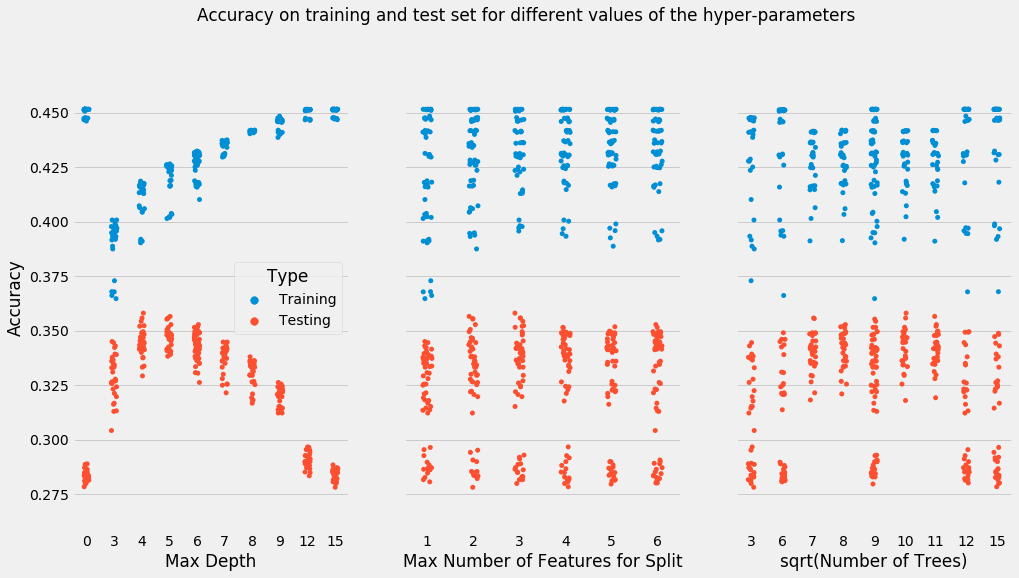

In [8]:
def getPlotAccuracy(accuracies, parameters):
    tempTrain = accuracies[parameters+['mean_train_score']]
    tempTrain.columns = parameters+['Accuracy']
    tempTest = accuracies[parameters+['mean_test_score']]
    tempTest.columns = parameters+['Accuracy']
    tempTrain['Type'] = 'Training'
    tempTest['Type'] = 'Testing'

    return pd.concat([tempTrain,tempTest],ignore_index=True)

def plotGridSearchRF(accuracies, parameters, xlabels):
    accuraciesForPlot = getPlotAccuracy(accuracies, parameters)

    #arguments used for all of the plots
    kwargsPlot = {'data':accuraciesForPlot,'y':'Accuracy','hue':'Type'}
    nParameters = len(parameters)
    f,axes = plt.subplots(nrows=1,ncols=nParameters,sharey=True)

    for i in range(nParameters):
        sns.stripplot(parameters[i],**kwargsPlot,ax=axes[i])
        axes[i].set_xlabel(xlabels[i])

        if i != 0:
            axes[i].get_legend().remove()


    f.set_size_inches(15,8)
    f.suptitle('Accuracy on training and test set for different values of the hyper-parameters')

    for ax in axes:
        ax.set_ylabel('')
    t=axes[0].set_ylabel("Accuracy")

parameters = ['param_max_depth','param_max_features','param_n_estimators']
xlabels = ['Max Depth','Max Number of Features for Split','sqrt(Number of Trees)']
plotGridSearchRF(accuracies,parameters,xlabels)

We immediately say a very clear trend line appearing for the max depth parameter, which actually seems to be basically the only relevant parameter. We will shortly verify this. However let's first comment on some of the trends. There is a very clear gap in the accuracies for the validation in the graphs for `maxFeatures` and `nTrees` which doesn't appear for some of the values of `nTrees`. This is simply a direct result of our implementation of gridsearch: the gaps are from the missing values which aren't checked in the finer search. If we were to include all possible values for the max depth in both searches they would disappear.
The second clear trend is the almost perfect inverse correlation between accuracy in validation and training in the first plot. It isn't clear if this also happens for the opther values, to find out we plot the two values against each other:

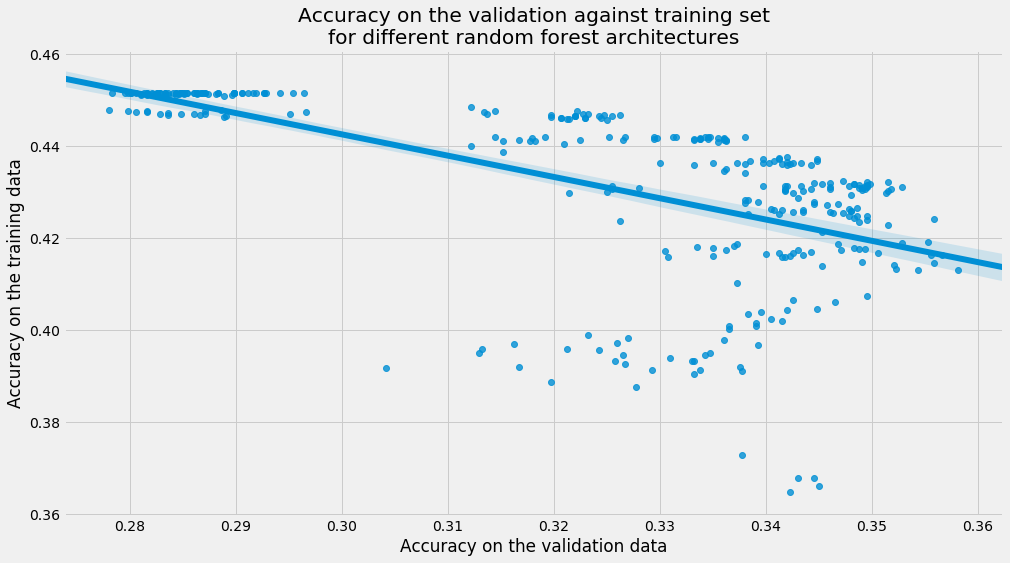

In [9]:
sns.regplot(accuracies['mean_test_score'],accuracies['mean_train_score'])
plt.title("Accuracy on the validation against training set\nfor different random forest architectures")
plt.xlabel("Accuracy on the validation data")
plt.ylabel("Accuracy on the training data")
plt.gcf().set_size_inches(15,8)
plt.show()

The previously supposed correlation now seems mostly due to a few outliers, however it hasn't entirely disappeared. This lines up with our expectations: the higher the training accuracy, the higher the risk of over-fitting.

To find the most important parameter we proceed as follows: for every parameter we iterate over each unique value. We look at the results which have that value for that particular parameter, and take their standard deviation. We then take the mean of all such obtained standard deviations. Intuitively this tells us how "spread out" the observations are for a certain fixed value of a parameter. If our accuracy only depended on one parameter it would have a mean standard deviation of exactly 0. The higher the value the less important a certain hyper-parameter. Note that `nTrees` and `maxDepth` will have a slight advantage as some of their values will only be acheived during the second iteration which has much less variability in the values of the parameter itself. the reason we don't correct for this is because of the shear difference between the value for `maxDepth` and the other two as shown below. Very clearly `maxDepth` is by far the most important value with `nTrees` and `maxFeatures` completely trailing. any correction would be much less impactful than this. So our first intuition from the plots above seems to be correct. A similar computation would also produce a very similar result for the accuracy on the training set, we however skip[ this as we are only interested on the effect on the validation data.

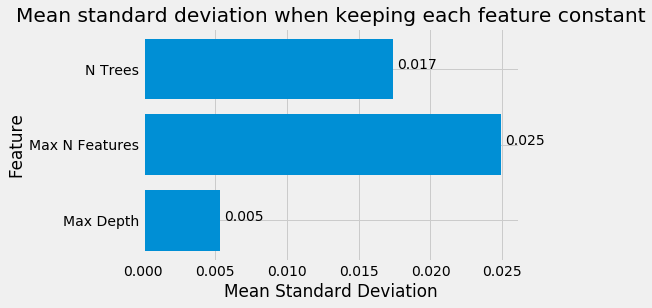

In [10]:
def computeMeanStdDev(constColumn,data,valueColumn='mean_test_score'):
    '''
    Computes the mean standard deviation of valueColumn when keeping the values in the specified column constant
    constColumn should be categoric while value column should be numeric
    '''
    vals = data[constColumn].unique()       #get all of the unique values that constColumn takes
    mean = 0.0
    for value in vals:
        relevant = data.loc[data[constColumn] == value]
        mean += relevant[valueColumn].std()
    mean /= len(vals)
    return mean

stdDevDepth = computeMeanStdDev('param_max_depth',accuracies)
stdDevFeatures = computeMeanStdDev('param_max_features',accuracies)
stdDevNTrees = computeMeanStdDev('param_n_estimators',accuracies)

fig, ax = plt.subplots()
stdDevs = [stdDevDepth,stdDevFeatures,stdDevNTrees]
ax.barh(['Max Depth','Max N Features','N Trees'], stdDevs, align='center')
ax.set_xlabel('Mean Standard Deviation')
ax.set_ylabel('Feature')
ax.set_title('Mean standard deviation when keeping each feature constant')

for i, stdDev in enumerate(stdDevs):
    ax.text(stdDev + 0.0003, i, "%.3f"%stdDev)
plt.show()

# Task 2
We will now perform a similar analysis but using a support vector classifier model. We will be checking three different kernels: linear, polynomial and rbf.
## Linear SVC
We first see whether changing the tollerance might allow us to reduce computation time: a higher tollerance will allow us to stop the iteration much faster. To do so we perform a gridsearch changing the cost and tollerance values.

In [11]:
from sklearn.svm import LinearSVC
svmScaler = MinMaxScaler()
svmScaler.fit(X)

Xsvm = svmScaler.transform(X)
linearSvc = LinearSVC()

coarseness = 20
Cs = np.linspace(0,2,coarseness+1)[1:]
tollerances = np.logspace(-4,-1,coarseness)
searchParameters = {'C':Cs,'tol':tollerances}

model = GridSearchCV(linearSvc,searchParameters,**gridSearchKwargs)
model = model.fit(Xsvm,y)
accuracies = pd.DataFrame(model.cv_results_)
relevantColumns = ['param_C','param_tol','mean_test_score','mean_train_score']
accuracies = accuracies[relevantColumns]

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 452 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1873 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   29.5s finished


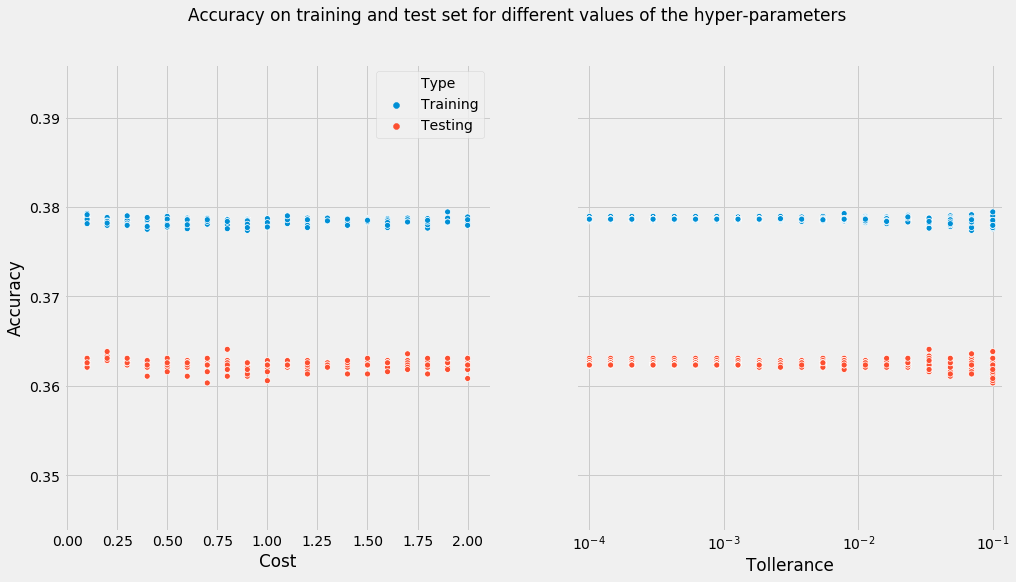

In [12]:
def plotGridSearchLinSVC(accuracies, parameters,xlabels):
    accuraciesForPlot = getPlotAccuracy(accuracies, parameters)

    #arguments used for all of the plots
    kwargsPlot = {'data':accuraciesForPlot,'y':'Accuracy','hue':'Type'}
    nParameters = len(parameters)
    f,axes = plt.subplots(nrows=1,ncols=nParameters,sharey=True)
    sns.scatterplot('param_C',**kwargsPlot,ax=axes[0])
    sns.scatterplot('param_tol',**kwargsPlot,ax=axes[1])
    axes[1].set_xscale('log')
    axes[1].set_xlim((0.8e-4,1.2e-1))

    for i in range(nParameters):
        axes[i].set_xlabel(xlabels[i])

        if i != 0:
            axes[i].get_legend().remove()


    f.set_size_inches(15,8)
    f.suptitle('Accuracy on training and test set for different values of the hyper-parameters')

    for ax in axes:
        ax.set_ylabel('')
    axes[0].set_ylabel("Accuracy")
plotGridSearchLinSVC(accuracies,['param_C','param_tol'],['Cost','Tollerance'])

In the figure above we can see that the amin feature visible on the graph seems to be an increase in how much the points are spread out as we increase the tollerance. We will quantify this by computing the standard deviation.

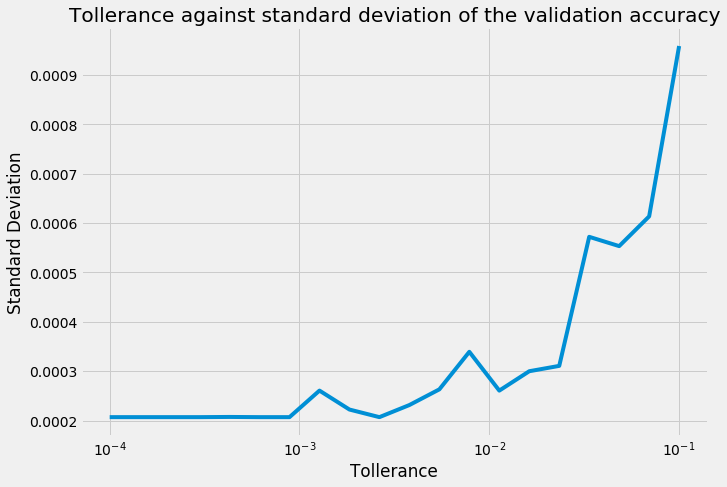

In [13]:
def computeStdDev(constColumn,data,valueColumn='mean_test_score'):
    '''
    Computes the mean standard deviation of valueColumn when keeping the values in the specified column constant
    constColumn should be categoric while value column should be numeric
    '''
    vals = data[constColumn].unique()       #get all of the unique values that constColumn takes
    stdDev = []
    for value in vals:
        relevant = data.loc[data[constColumn] == value]
        stdDev += [relevant[valueColumn].std()]
    return stdDev
plt.semilogx(tollerances,computeStdDev('param_tol',accuracies))
plt.xlabel("Tollerance")
plt.ylabel("Standard Deviation")
plt.title("Tollerance against standard deviation of the validation accuracy")
plt.gcf().set_size_inches(10,7)
plt.show()

The trend is very clearly increasing. This tells us that increasing the tollerance will result in less trustworthy results: the validation accuracy might happen to be high, but that will be a result of the random split in our dataset and will not generalise to the test set. In other words we would be in a sense over-fitting on the validation data. To avoid it we keep the tollerance to the default value of $10^{-3}$. We now only need to fine tune the cost parameter for the linear SVC.

In [14]:
Cs = np.linspace(0,2,coarseness*4)[1:]
searchParameters = {'C':Cs}
linearSvc = LinearSVC()

model = GridSearchCV(linearSvc,searchParameters,**gridSearchKwargs)
model = model.fit(Xsvm,y)

trainedLSVC = model.best_estimator_
bestScoreLinear = model.best_score_

accuraciesC = pd.DataFrame(model.cv_results_)
relevantColumns = ['param_C','mean_test_score','mean_train_score']
accuraciesC = accuraciesC[relevantColumns]

Fitting 5 folds for each of 79 candidates, totalling 395 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 395 out of 395 | elapsed:   10.9s finished


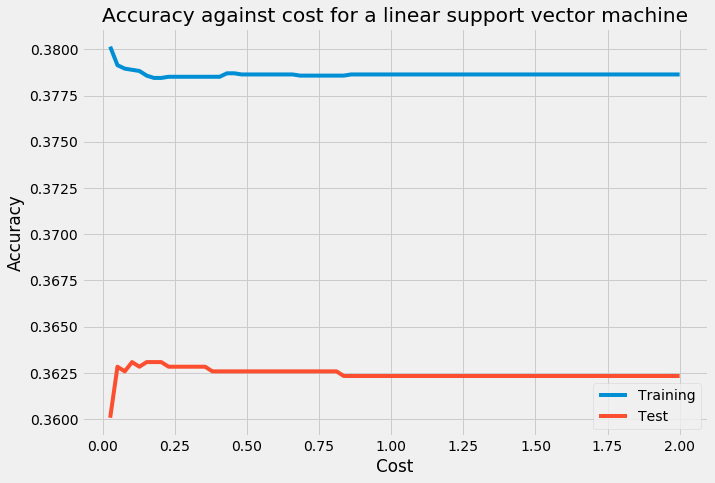

In [15]:
plt.plot(Cs,accuraciesC['mean_train_score'],label="Training")
plt.plot(Cs,accuraciesC['mean_test_score'],label="Test")
plt.title("Accuracy against cost for a linear support vector machine")
plt.xlabel("Cost")
plt.ylabel("Accuracy")
plt.legend()
plt.gcf().set_size_inches(10,7)

As might be expected, a very low cost will result in a poor model. After quickly increasing, the validation accuracy slowly decreases, indicating that setting too high of a cost will result in over-fitting the training data.

## Polynomial SVC
We've learnt above that changing the tollerance is not recommended, so we will keep it to the default value. This leaves us with two parameters to optimise for the polynomial SVC: cost and degree of the polynomial. We could also optimise the value of gamma, however the literature shows that this in general is unnecessary, furthermore large value fo gamma lead to extremely long computation times, which means that the effective range we could optimise it over would be extremely restricted.

In [16]:
from sklearn.svm import SVC
polySvc = SVC(kernel='poly')
nVals = 15

Cs = np.linspace(0,0.8,nVals)[1:]
degrees = [2,3,5,7,10]
searchParameters = {'C':Cs,'degree':degrees}

model = GridSearchCV(polySvc,searchParameters,**gridSearchKwargs)
model = model.fit(Xsvm,y)
accuraciesPoly = pd.DataFrame(model.cv_results_)
relevantColumns = ['param_C','param_degree','mean_test_score','mean_train_score']
accuraciesPoly = accuraciesPoly[relevantColumns]

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   33.6s finished


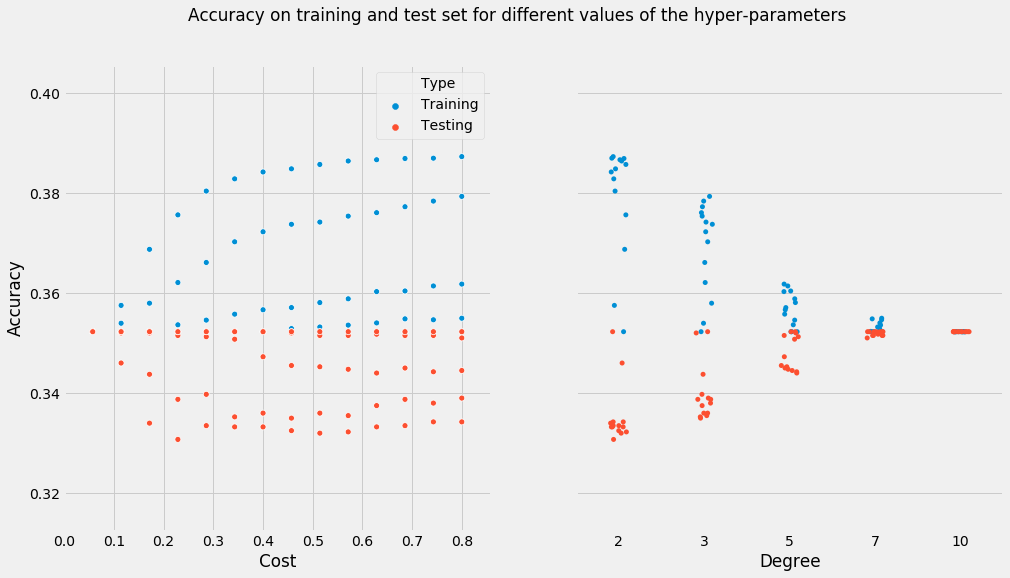

In [17]:
def plotGridSearchPolySVC(accuracies, parameters,xlabels):
    accuraciesForPlot = getPlotAccuracy(accuracies, parameters)

    #arguments used for all of the plots
    kwargsPlot = {'data':accuraciesForPlot,'y':'Accuracy','hue':'Type'}
    nParameters = len(parameters)
    f,axes = plt.subplots(nrows=1,ncols=nParameters,sharey=True)

    sns.scatterplot('param_C',**kwargsPlot,ax=axes[0])
    sns.stripplot('param_degree',**kwargsPlot,ax=axes[1])

    for i in range(nParameters):
        axes[i].set_xlabel(xlabels[i])

        if i != 0:
            axes[i].get_legend().remove()


    f.set_size_inches(15,8)
    f.suptitle('Accuracy on training and test set for different values of the hyper-parameters')

    for ax in axes:
        ax.set_ylabel('')
    axes[0].set_ylabel("Accuracy")

plotGridSearchPolySVC(accuraciesPoly,['param_C','param_degree'],['Cost',"Degree"])

The more interesting trend is that given by the second plot above. As the degree increases both the validation and training accuracy approach ~35.5%. This is very simiolar to the proportion of unacceptable cars, which is the plurality class. This suggests that the model is becoming more and more like the dummy model which just predicts the most common class. This can be explained by noting that with high degree polynomials we have extreme sensibility to the input. As our data is categorical, even the smallest change will lead to wild swings in the output value. To avoid these we need to fix a low enough value for the degree. The default 3 seems like a reasonable choice.

Fitting 5 folds for each of 59 candidates, totalling 295 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 295 out of 295 | elapsed:   26.9s finished


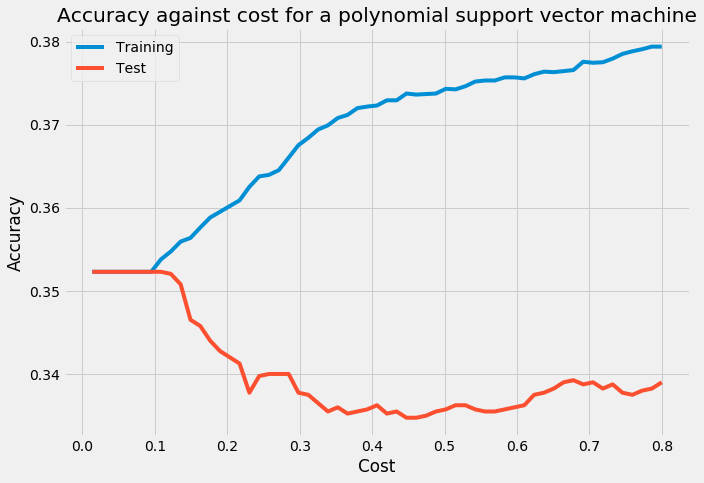

In [18]:
polySVC = SVC(kernel='poly',degree=3)

Cs = np.linspace(0,0.8,nVals*4)[1:]
searchParameters = {'C':Cs}

model = GridSearchCV(polySvc,searchParameters,**gridSearchKwargs)
model = model.fit(Xsvm,y)
accuraciesPoly = pd.DataFrame(model.cv_results_)
plt.plot(Cs,accuraciesPoly['mean_train_score'],label="Training")
plt.plot(Cs,accuraciesPoly['mean_test_score'],label="Test")
plt.title("Accuracy against cost for a polynomial support vector machine")
plt.xlabel("Cost")
plt.ylabel("Accuracy")
plt.legend()
plt.gcf().set_size_inches(10,7)

trainedPolySvc = model.best_estimator_
bestScorePoly = model.best_score_

Unfortunately the behaviour described above seems to be appearing once again, the best values are given by the dummy model, with clear overfitting for other values of the cost. This suggests that a polynomial SVC is probably not very adequate.

## RBF SVC
The final kernel we will consider is RBF. As changing gamma doesn't lead to as high computation times as in the polynomial case, we will try to also optimise it. Leading once agaion to two values considered for optimisation: cost and gamma. Like in the random forest case we first perform a coarse search and then repeat a finer search.

In [19]:
nVals = 8
Cs = np.linspace(0,0.8,nVals)[1:]
gammas = np.linspace(0,3,nVals)[1:]
searchParameters = {'C':Cs,'gamma':gammas}

model = GridSearchCV(SVC(),searchParameters,**gridSearchKwargs)
model = model.fit(Xsvm,y)
accuraciesRBF = pd.DataFrame(model.cv_results_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:   30.6s finished


In [20]:
bestC = model.best_params_['C']
bestGamma = model.best_params_['gamma']

intervalScale = 0.9 / nVals
Cs = np.linspace(max(bestC-intervalScale,1e-5),bestC+intervalScale,nVals)
gammas = np.linspace(max(bestGamma-intervalScale*3,1e-5),bestGamma+intervalScale*5,nVals)
searchParameters = {'C':Cs,'gamma':gammas}

model = GridSearchCV(SVC(),searchParameters,**gridSearchKwargs)
model = model.fit(Xsvm,y)

accuraciesRBF = accuraciesRBF.append(pd.DataFrame(model.cv_results_))
relevantColumns = ['param_C','param_gamma','mean_test_score','mean_train_score']
accuraciesRBF = accuraciesRBF[relevantColumns]

trainedRBFSvc = model.best_estimator_
bestScoreRBF = model.best_score_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   39.1s finished


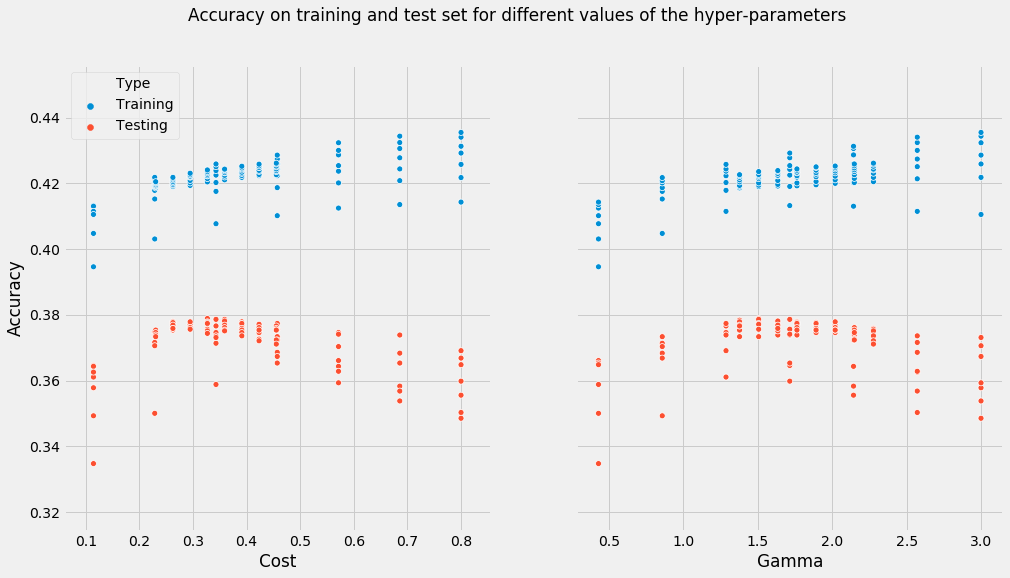

In [21]:
def plotGridSearchRBFSVC(accuracies, parameters,xlabels):
    accuraciesForPlot = getPlotAccuracy(accuracies, parameters)

    #arguments used for all of the plots
    kwargsPlot = {'data':accuraciesForPlot,'y':'Accuracy','hue':'Type'}
    nParameters = len(parameters)
    f,axes = plt.subplots(nrows=1,ncols=nParameters,sharey=True)

    sns.scatterplot('param_C',**kwargsPlot,ax=axes[0])
    sns.scatterplot('param_gamma',**kwargsPlot,ax=axes[1])

    for i in range(nParameters):
        axes[i].set_xlabel(xlabels[i])

        if i != 0:
            axes[i].get_legend().remove()


    f.set_size_inches(15,8)
    f.suptitle('Accuracy on training and test set for different values of the hyper-parameters')

    for ax in axes:
        ax.set_ylabel('')
    axes[0].set_ylabel("Accuracy")
plotGridSearchRBFSVC(accuraciesRBF,['param_C','param_gamma'],['Cost',"Gamma"])

Both the cost and gamma seem to be affecting the accuracy in a vert similar way: increasing them always results in a better accuracy on the training set, but afgter a point we encounter some overfitting. In any case this is clearly behaving much better than the polynomial SVC.

In [22]:
scores = [bestScoreLinear, bestScorePoly, bestScoreRBF]
trainedSVCs = [trainedLSVC, trainedPolySvc, trainedRBFSvc]
index = scores.index(max(scores))

trainedSVC = trainedSVCs[index]

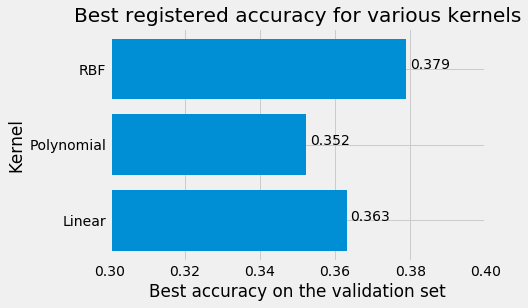

In [23]:
fig, ax = plt.subplots()

ax.barh(['Linear','Polynomial','RBF'], scores, align='center')
ax.set_xlabel('Best accuracy on the validation set')
ax.set_ylabel('Kernel')
ax.set_title('Best registered accuracy for various kernels')
ax.set_xlim((0.3,0.4))

for i, score in enumerate(scores):
    ax.text(score + 0.001, i, "%.3f"%score)
plt.show()

As expected the best accuracy is obtained by the RBF, followed by linear and finally polynomial SVC. 

# Task 3
As we will be performing a very similar procedure repeatedly, object oriented programming is going to be very useful in avoiding repetition and imporving readability of the code. All of our networks will inherit from the same base class. None of the networks feature an activation of the final layer: during training the most sensible activation would be softmax, but this is included by the cross entropy criterion. When we use the network for predictions we are only interested in the value with the highest chance, as softmax doesn't change which class receives the highest score, computing softmax would be simply a wast of computational resources.

The data needs to be preprocessed before being used in the neural network: we will standardise every predictor on a linear scale between 0 and 1, where 1 represents the lowest value in each cathegory and 1 the highest. This normalisation will be done automatically by the network, so it can be fed raw observations. We start by preparing a class that will store the datasets.

In [24]:
import torch
import torch.nn as nn
nnScaler = MinMaxScaler()           #maps the largest value in a dataset to 1 and the smallest to 0 linearly fitting all the others

useCuda = torch.cuda.is_available()
nnScaler = nnScaler.fit(X)          #fit the scaler to the training dataset

N_PREDICTORS = 6
N_RATINGS = 4
N_EPOCHS = 120

class NNDataset(torch.utils.data.Dataset):
    '''
    Class to store the datasets for the neural networks
    '''
    def __init__(self,X,y):
        #convert data to PyTorch tensors
        self.X = torch.from_numpy(nnScaler.transform(X)).float()
        nny = np.array(y,dtype=int)
        self.y = torch.from_numpy(nny).long()
        
        #transfer data to VRAM
        if useCuda:
            self.X = self.X.cuda()
            self.y = self.y.cuda()
    
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self,index):
        return self.X[index],self.y[index]

We can now write our neural network class. By calling the training and prediction methods fit and predict, we can seemlessly integrate it with any function which expects sklearn models. Note that the best approach to do this would be to have the class inherit from sklearn modules, but this would require to majorly change the structure of the code (or using a module like skorch) and given our use case it won't make much difference.

In [25]:
class NNBase(nn.Module):
    '''
    Basic class from which all neural networks are inherited
    This is an abstract class which cannot be instantiated
    '''
    def __init__(self,learningRate, batchSize, verbose, validate):
        super(NNBase,self).__init__()
        self.criterion = nn.CrossEntropyLoss()
        self.learningRate = learningRate
        self.batchSize = batchSize
        self.verbose = verbose
        self.validate = validate
    
    @staticmethod
    def forward(self, X):
        pass

    def reset(self):
        '''
        Resets all parameters in the network, useful if training the same network
        more than once on different datasets
        '''
        def resetWeight(m):
            if isinstance(m, nn.Linear):
                m.reset_parameters()
        self.apply(resetWeight)

    def fit(self, X, y):
        '''
        Train the network on the dataset X with labels y
        Returns in-sample and out-of-sample loss during training
        '''
        validate = self.validate    #wether to reserve some of the data for validation
        dataset = NNDataset(X,y)

        #split the dataset into validation and training if required otherwise only use training
        if validate:
            trainSize = int(0.8 * len(dataset))
            validationSize = len(dataset) - trainSize
            trainDataset, validationDataset = torch.utils.data.random_split(dataset, [trainSize, validationSize])
        else:
            trainSize = len(dataset)
            trainDataset = dataset
        self.train()        #put network in training mode, necessary to activate the dropout layers
        self.reset()        #reset all weights

        if useCuda: #compute on GPU
            self.cuda()

        optimiser = torch.optim.SGD(self.parameters(),lr=self.learningRate)
        loader = torch.utils.data.DataLoader(dataset=trainDataset,batch_size=self.batchSize,shuffle=True)

        #I know this is not the right way to do this but the efficiency loss is negligible 
        if validate:
            loaderValidation = torch.utils.data.DataLoader(dataset=validationDataset,batch_size=validationSize,shuffle=False)
            xVal, yVal = next(iter(loaderValidation))   #get all of the valiudation data (note that the batch size is the same as the dataset size)

        lossTrain = []
        lossValidation = []

        for epoch in range(N_EPOCHS):
            currLoss = 0.0
            for predictors, ratings in loader:
                optimiser.zero_grad()   #the optimiser will have the values from the previous iteration, so it needs to be reset
                outputs = self(predictors)  #apply the neural network to the predictors to get predicted ratings
                loss = self.criterion(outputs, ratings) #calculate the loss

                loss.backward()  #calculate the derivative of the loss
                optimiser.step()  #update weights

                currLoss += loss.item() * predictors.size(0)    #save the current loss, we multiply by the size of the batch to normalise
            lossTrain.append(currLoss/trainSize)        #divide by the total number of elements in the training dataset
            if validate:    #calculate the loss on the validation dataset
                outputsVal = self(xVal)
                loss = self.criterion(outputsVal,yVal)
                lossValidation.append(loss.item())
                
            if ((epoch+1) % 5 == 0) and self.verbose:
                print('\rEpoch [%d/%d]'%(epoch+1, N_EPOCHS),end='')

        if validate:
            return lossTrain, lossValidation
        return lossTrain
    
    def predict(self, X):
        self.eval()     #deactivate the dropout layer
        x = torch.from_numpy(nnScaler.transform(X)).float()  #convert X to a PyTorch tensor
        if useCuda:
            x = x.cuda()
        y = self(x).cpu().detach().numpy().argmax(axis=1)   #convert y into a numpy array, then find the maximum value and return its index, as the index corresponds exactly to the rating this will return the highest probability class
        return y
    

The next class is used by all networks with a shallow architecture. Though only some of them are supposed to have a dropout layer, this is indistinguishable from the case where the dropout chance is 0. The impact on efficiency is completely negligible as PyTorch recognises that this is equivalent as having an identity function and immediately returns the value given to the function.

In [26]:
class NNShallow(NNBase):
    '''
    Neural network with two hidden layers, the first one of which is dropped out in training
    By default the dropout rate will be zero
    '''
    def __init__(self, learningRate=1e-2, batchSize=64, dropoutChance=0, verbose=True, activationFun = nn.ReLU(), validate = True):
        super(NNShallow, self).__init__(learningRate, batchSize, verbose, validate)
        self.layer1 = nn.Linear(N_PREDICTORS, 200)
        self.layer2 = nn.Linear(200, 200)
        self.layer3 = nn.Linear(200, N_RATINGS)
        self.dropoutChance = dropoutChance
        self.dropoutLayer = nn.Dropout(p = self.dropoutChance)
        self.activation = activationFun
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.dropoutLayer(out)
        out = self.activation(out)
        out = self.layer2(out)
        out = self.activation(out)
        out = self.layer3(out)
        return out

We now train the basic network with a learning rate of 0.01, no dropout layer, and a batch size of 64 to use as a benchmark.

In [27]:
from datetime import datetime   #used to time execution of code
networkBase = NNShallow()

#use GPU to accelerate if available
if useCuda:
    networkBase.cuda()

start = datetime.now()
lossBase,lossBaseVal = networkBase.fit(X,y) #train network using X as predictor and y as labels
timeBase = datetime.now() - start

Epoch [120/120]

# Task 3.1
The first thing we alter is the learning rate: we train two neural networks with a very large and very small learning rate. Then we plot for each of them the loss on the training and validation sets.

In [28]:
networkFastLearning = NNShallow(learningRate=0.95)
networkSlowLearning = NNShallow(learningRate=5e-4)

if useCuda:
    networkFastLearning.cuda()
    networkSlowLearning.cuda()

lossFast,lossFastVal = networkFastLearning.fit(X,y)
print()
lossSlow,lossSlowVal = networkSlowLearning.fit(X,y)

Epoch [120/120]
Epoch [120/120]

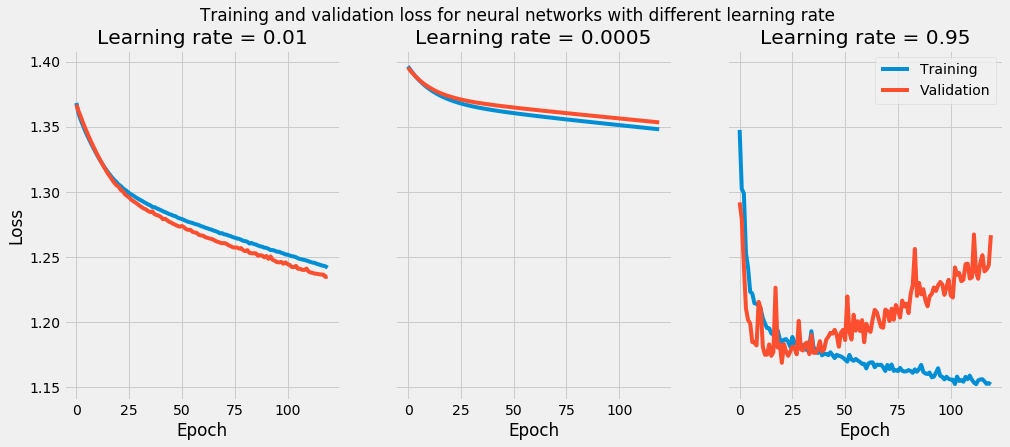

In [29]:
fig, axes = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(15,6)
fig.suptitle("Training and validation loss for neural networks with different learning rate")

axes[0].plot(lossBase)
axes[0].plot(lossBaseVal)
axes[0].set_ylabel("Loss")
axes[0].set_title("Learning rate = 0.01")

axes[1].plot(lossSlow)
axes[1].plot(lossSlowVal)
axes[1].set_title("Learning rate = 0.0005")

axes[2].plot(lossFast,label="Training")
axes[2].plot(lossFastVal,label="Validation")
axes[2].set_title("Learning rate = 0.95")
axes[2].legend()

for ax in axes:
    ax.set_xlabel("Epoch")
plt.show()

First, one small note on the way we calculate the validation loss. The best way would be to use different splits at every epoch, or build a balanced split. Either of the two possibilities is however unnecessarily complicated: the trends are clear enough to not need the extra precision. This means that it is quite possible that some of the graphs will show a validation loss consistently lower than the training one, due to differently balanced splits, but this will average out over multiple runs of the code to produce the expected result.

We now proceed with the discussion of the above plots. These might slightly change from run to run but the main trends remain consistent. A learning rate of 0.01 is the clear choice. When it is set to 5 e-4 we do have very little overfitting, but this is mainly do to a basically complete lack of fitting in the first place. To get a predictive power similar to the base one we would need to train the network for many more epochs, resulting in longer computations.

A learning rate of 0.95 has the opposite effect: a much lower loss on the training data but very clear overfitting with the network actually losing predictive power as the number of epochs increases. Though, when the number of epochs is very low (~5) the network seems to have low overfitting while having a loss which is achieved by the basic network over many more epochs. While, naively, we might think to simply train the network for only a few epochs with the higher learning rate, this results in huge variability in the actual chance of overfitting, as can be seen by the high irregularity of the validation loss. STill, this suggests that a learning rate slightly higher than 0.01 might lead to better convergence.

In any case, 0.01 is very clearly the best learning rate out of the three, with very little overfitting and low enough loss.

# Task 3.2
We repeat the steps of the previous task, this time keeping the learning rate fixed at 0.01 and changing the batch size, first to 256 and then to 2.

In [30]:
#Train neural network with big bacth size
networkBigBatch = NNShallow(batchSize = 256)
if useCuda:
    networkBigBatch.cuda()

start = datetime.now()
lossBig,lossBigVal= networkBigBatch.fit(X,y)
timeBig = datetime.now() - start

Epoch [120/120]

In [31]:
#Train neural network with small batch size
networkSmallBatch = NNShallow(batchSize = 2)
if useCuda:
    networkSmallBatch.cuda()

start = datetime.now()
lossSmall,lossSmallVal = networkSmallBatch.fit(X,y)
timeSmall = datetime.now() - start

Epoch [120/120]

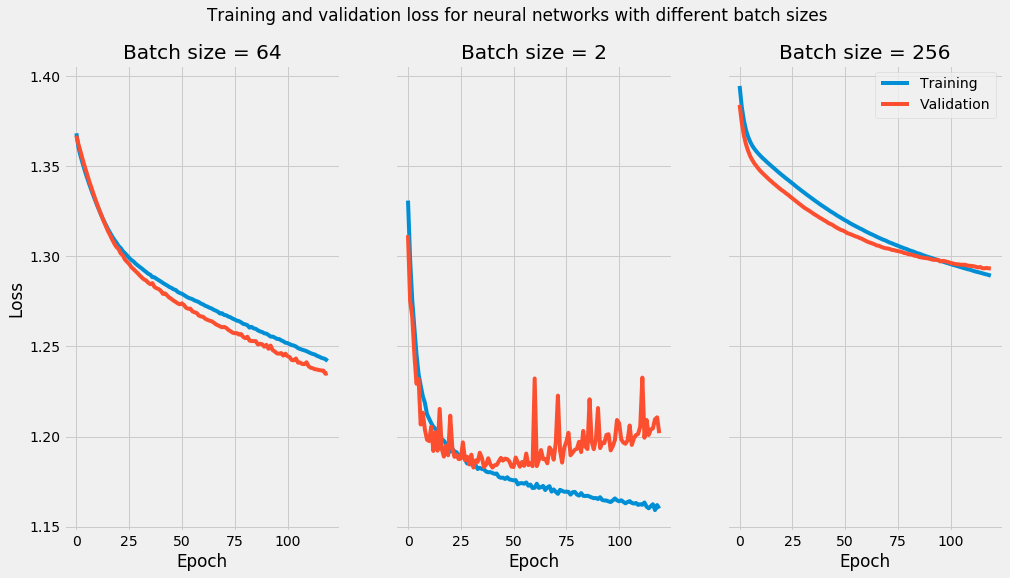

In [32]:
fig, axes = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(15,8)
fig.suptitle("Training and validation loss for neural networks with different batch sizes")

axes[0].plot(lossBase)
axes[0].plot(lossBaseVal)
axes[0].set_ylabel("Loss")
axes[0].set_title("Batch size = 64")

axes[1].plot(lossSmall)
axes[1].plot(lossSmallVal)
axes[1].set_title("Batch size = 2")

axes[2].plot(lossBig,label="Training")
axes[2].plot(lossBigVal,label="Validation")
axes[2].set_title("Batch size = 256")
axes[2].legend()

for ax in axes:
    ax.set_xlabel("Epoch")
plt.show()

We again see similar behaviour as before: a small batch size has good loss on the training data, but overfits too much; a big batch size doesn't result in overfitting but has very slow convergence; a batch size of 64 seems to balance the two out well enough. The discussion is then very much the same as above, however we have to note one thing: the validation loss for the small batch size isn't as variable as the one for a big learning rate. This means that reducing the number of epochs might actually be a valuable strategy. In fact a batch size of 1 leads to the fastest possible convergence \[1, Table 2\], this is assuming infinite amount of observations. In general a cutoff has to be made between speed of convergence and final loss value: if the task is computationally restricted a smaller batch size is to be preferred, however if the task is data-restricted larger batch sizes will be more appropriate.

In our experimental setup we are keeping the number of epochs constant which greatly weighs on the execution time of the supposedly fastest neural network architecture. As the plot below shows a batch size of two leads to a massive increase in computation time, most of which is wasted on overtraining the network. This is also further bottlenecked by the architecture of modern GPUs: these work well on extremely parallelisable tasks. When the batch size is as small as 2, there is a good chance that most CUDA cores will remain idle. 

In any case, the batch size and number of epochs should be based on the amount of computation power and data available. Given the scenario proposed in the coursework, the best approach would probably be that of performing full gradient descent. This would be very computationally intensive, but even if the computation time were say, 24 hours, this would be acceptable for even a small gain in accuracy, given that a misclassification of even a single car might cost thousands of dollars, which far outweighs the cost of the necessary CPU-time.

That said we must face the constraints of this coursework, where a training time of more than a few minutes would be prohibitively high, so we again stick with the base value for the hyperparameter which gives a good trade off between computation time and accuracy.

[1]: Bottou, L., 2010. _Large-scale machine learning with stochastic gradient descent._ In Proceedings of COMPSTAT'2010 (pp. 177-186). Physica-Verlag HD.

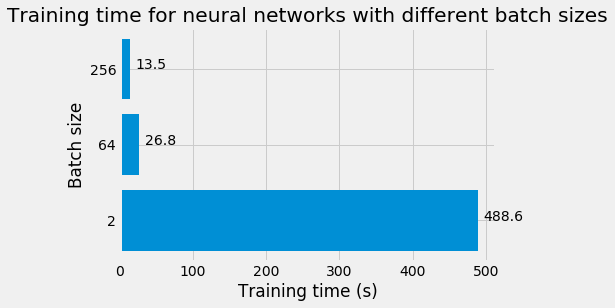

In [33]:
from datetime import timedelta
norm = timedelta(seconds=1)
fig, ax = plt.subplots()
times = [timeSmall / norm,timeBase / norm,timeBig / norm]
ax.barh(['2','64','256'], times, align='center')
ax.set_xlabel('Training time (s)')
ax.set_ylabel('Batch size')
ax.set_title('Training time for neural networks with different batch sizes')

for i, t in enumerate(times):
    ax.text(t + 8, i, "%.1f"%t)

# Task 3.3
We now activate the dropout layer in our network, and use stratified 5-fold validation to fine tune its value. The computation is extremely expensive as for each value of the dropout rate we need to train the equivalent of 5 neural networks, we thus limit ourselves to just 11 different values of the dropout rate. As we are already using validation at the end of the training, it becomes superfluous to also validate the model during training.

We will also include a dropout rate of 100% in our search. Any such trained neural network will have no way to access the predictor data during training, meaning that it should converge to the dummy predictor of always predicting the most common class. This should give us a good baseline on which to judge the other values.

In [34]:
%%time
from sklearn.metrics import accuracy_score
N_EPOCHS = 120 #Just for safety
dropoutChances = np.linspace(0.0,1.0,11)
nDropouts = len(dropoutChances)

accuraciesDropout = []
#stratified k-fold validation to optimise tune the dropout-chance

for i, dropoutChance in enumerate(dropoutChances):      
    currAccuracy = 0.0
    for j, (trainI, testI) in enumerate(skf.split(X, y)): 
        Xtrain, Xtest = X.iloc[trainI], X.iloc[testI]   #split the dataset
        ytrain, ytest = y.iloc[trainI], y.iloc[testI]

        net = NNShallow(dropoutChance = dropoutChance, verbose = False, validate = False)
        if useCuda:
            net.cuda()
        net.fit(Xtrain,ytrain)      #train network
        yPred = net.predict(Xtest)  #make prediction

        currAccuracy += accuracy_score(ytest, yPred)    #add the accuracy for the current split
        print("\rDropout chance [%d/%d] --- Fold [%d/%d]"%(i+1,nDropouts,j+1,NFOLDS),end='')
    accuraciesDropout.append(currAccuracy / NFOLDS)    #divide by NFOLDS to normalise

bestDropout = dropoutChances[np.array(accuraciesDropout).argmax()]
#bestDropout = 0.65
trainedNetwork = NNShallow(dropoutChance=bestDropout, validate=False)
if useCuda:
    trainedNetwork.cuda()

trainedNetwork.fit(X,y)

Epoch [120/120]Wall time: 21min 9s


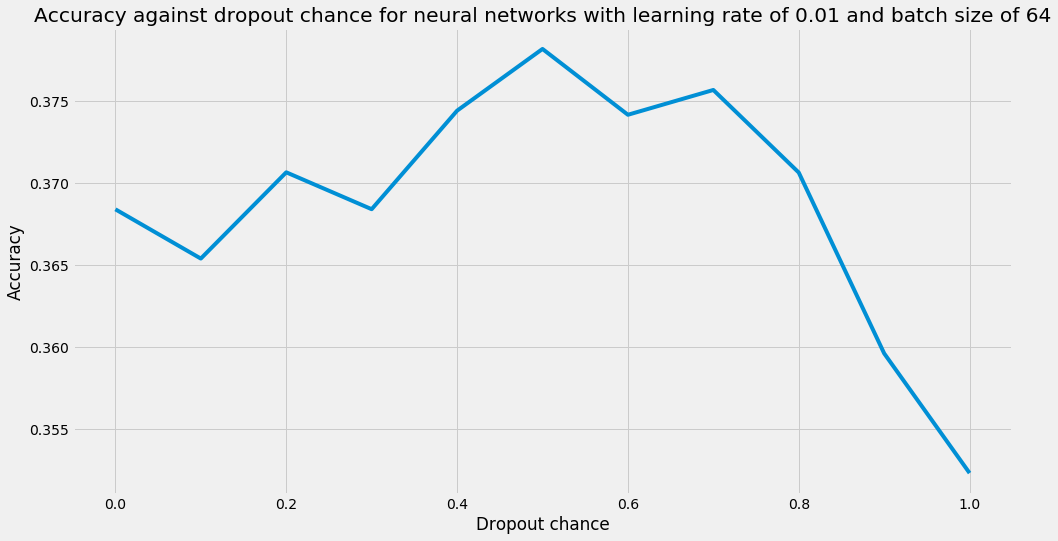

In [35]:
plt.plot(dropoutChances,accuraciesDropout)
plt.title("Accuracy against dropout chance for neural networks with learning rate of 0.01 and batch size of 64")
plt.xlabel("Dropout chance")
plt.ylabel("Accuracy")
plt.gcf().set_size_inches(15,8)

The general trend seems to be of the accuracy slowly increasing with the dropout chance, before sharply falling at around 0.9. As expected, the network with a dropout rate of 100% has an accuracy of about 35%, this is close to the number of elements in the biggest class, meaning that the network will ignore all else and just try to always output the most common class. Disparagingly, even in the best case, we only get an increase in accuracy by only a few percentage points over this baseline. This suggests that our model isn't performing as well as we might have hoped for.

# Task 4.1

In [47]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy = 'most_frequent')
dummy=dummy.fit(X,y)    #always predicts the most frequent class

In [48]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
warnings.simplefilter(action='ignore', category=sklearn.exceptions.UndefinedMetricWarning)
classLabels = ['unacc','acc','good','vgood']

def getReport(predictors,trueLabels,model,modelName="???"):
    '''
    Returns a complete report for accuracy, f1 score and precision of a given model, together with the confusion matrix
    '''
    predictedLabels = model.predict(predictors)
    classificationReport = "Classification report for model: %s\n"%modelName+classification_report(trueLabels, predictedLabels, target_names=classLabels)
    confusionMatrix = confusion_matrix(trueLabels, predictedLabels)
    return classificationReport, confusionMatrix

In [120]:
models = [dummy, trainedNetwork, trainedForest, trainedSVC]
modelNames = ["dummy", "neural network", "random forest", "support vector classifier"]
Xs = [XTest,XTest,rfScaler.transform(XTest),svmScaler.transform(XTest)]

#get report and confusion matrix for all studied models
reports = [None]*4
confusionMatrices = [None]*4
for i, name in enumerate(modelNames):
    reports[i], confusionMatrices[i] = getReport(Xs[i],yTest,models[i],name)

In [51]:
for report in reports:
    print(report+"\n-------------------------\n")

Classification report for model: dummy
              precision    recall  f1-score   support

       unacc       0.42      1.00      0.59       412
         acc       0.00      0.00      0.00       188
        good       0.00      0.00      0.00       204
       vgood       0.00      0.00      0.00       188

    accuracy                           0.42       992
   macro avg       0.10      0.25      0.15       992
weighted avg       0.17      0.42      0.24       992

-------------------------

Classification report for model: neural network
              precision    recall  f1-score   support

       unacc       0.63      0.81      0.71       412
         acc       0.45      0.24      0.31       188
        good       0.49      0.32      0.39       204
       vgood       0.50      0.60      0.54       188

    accuracy                           0.56       992
   macro avg       0.51      0.49      0.49       992
weighted avg       0.54      0.56      0.53       992

----------------

Even though it might not have seen that way during training, all three models seem to perform quite a bit better than the baseline dummy model. In particular the accuracy has risen from ~37% to around 55-60%. This is hard to explain without assuming that the distribution of the testing data is somewhat more forgiving. In general all three models have a good balance between precision and recall all across. The big exception is that the recall rate for cars rated acceptable is always very low, and in the case of random forests it is completely abysmal. Apart from that random forest and neural network behave similarly, while the support vector machine seems to be slightly better than both of them.

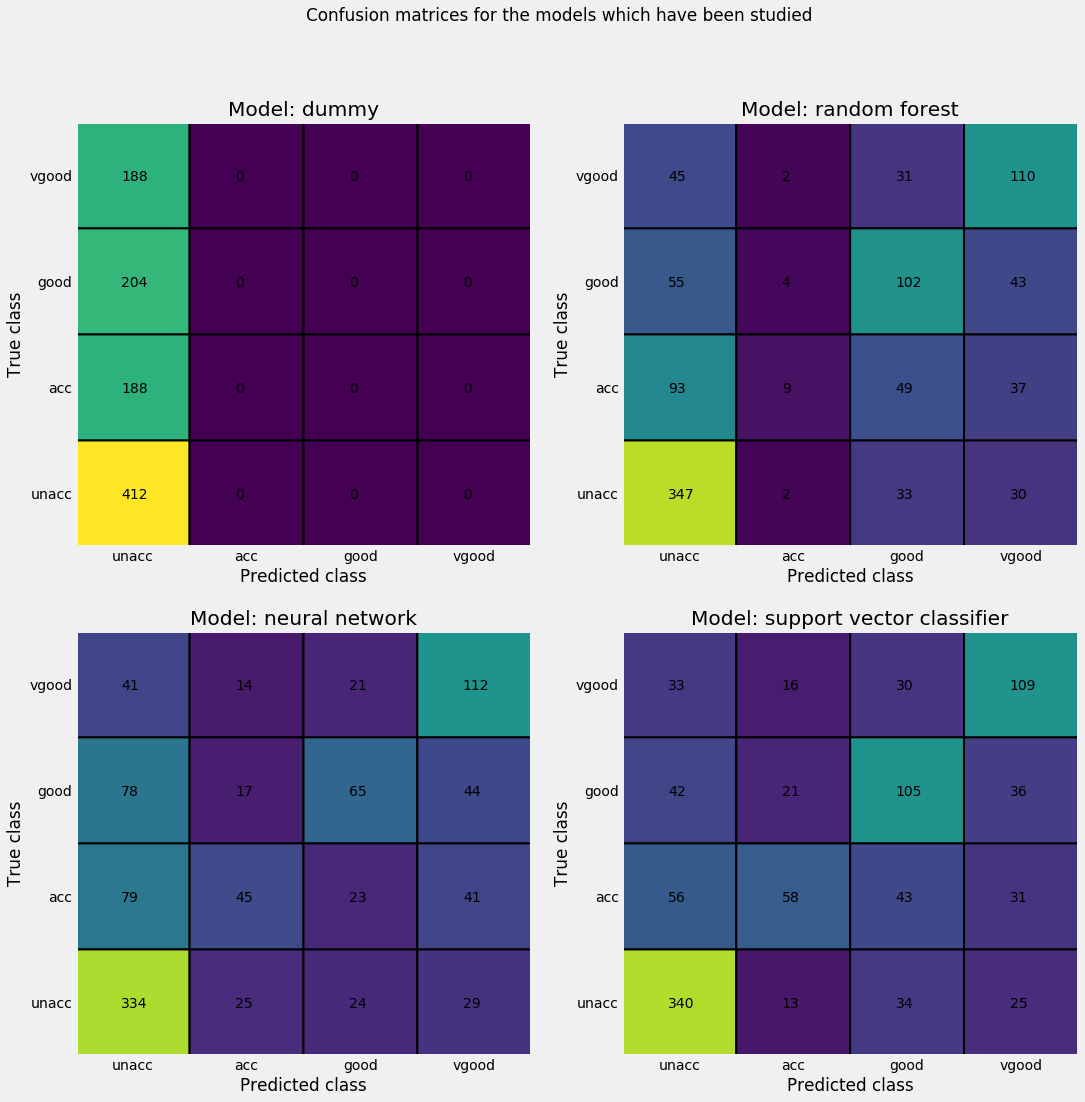

In [103]:
import matplotlib.colors as colors
def plotConfusionMatrix(confusionMatrices,modelNames):
    f,axes = plt.subplots(nrows=2,ncols=2)

    vmax=max([np.amax(mat) for mat in confusionMatrices])

    divnorm = colors.DivergingNorm(vmin=0, vcenter=100, vmax=vmax)

    for i in range(len(confusionMatrices)):
        ax = axes[i%2, i//2]
        ax.pcolor(confusionMatrices[i], norm=divnorm,cmap="viridis",edgecolor="black",linewidths=2)

        ax.set_yticks([0.5,1.5,2.5,3.5],minor=False)
        ax.set_yticklabels(classLabels)
        ax.set_xticks([0.5,1.5,2.5,3.5],minor=False)
        ax.set_xticklabels(classLabels)
        for tick in ax.get_xticklabels():
            tick.set_rotation(0)
        
        ax.set_ylabel("True class")
        ax.set_xlabel("Predicted class")
        ax.set_title("Model: %s"%modelNames[i])

        for j in range(4):
            for k in range(4):
                ax.text(k+0.4,j+0.45,"%d"%confusionMatrices[i][j,k])

    f.set_size_inches(16,16)
    f.suptitle("Confusion matrices for the models which have been studied")
    plt.show()
plotConfusionMatrix(confusionMatrices, modelNames)

Looking at the confusion matrices gives us a clearer picture: all three methods seem to be too eager to predict a car to be unacceptable. Since unacceptable is the plurality class, this is to be expected. Random forest seemingly ignores unacceptable cars: whenever a car has even a low chance of being of poor quality it will immediately predict it as being unacceptable. It then performs much better for good and very good cars. On the other hand neural network is more willing to predict a car as acceptable. This can probably be explained by the fact that in training neural network is the only model which gets point for being close: cross entropy loss looks at predicted probabilities, meaining that the network learns to hedge. Thus it isn't as severely penalised for predicting a car to be acceptable when it turns out as being unacceptable, so long as it also gives a high probability for unacceptable. However it then performs almost as bad for good cars, showing extremely similar behaviour for both acceptable and good cars.

Finally, SVM manages to avoid both problems. It has a decent recall rate on acceptable cars, while also being very capable in identifying good cars. This is what gives it the slight edge on the other two classes.

# Task 4.2
One thign which we haven't been able to capture is how close a certain guess is. Both in the training of the models and in the discussion above we have only checked whether a certain prediction is correct or not. However predicting a very good car as unacceptable is much worse than say predicting a good car as very good. Thus we must use some sort of metric that is able to capture this information to make a more informed decision.

In [121]:
def getScore(confusionMatrix):
    score = 0
    for i in range(4):
        for j in range(4):
            score += confusionMatrix[i,j]*abs(j-i)
    return score

scores = [getScore(mat) for mat in confusionMatrices]

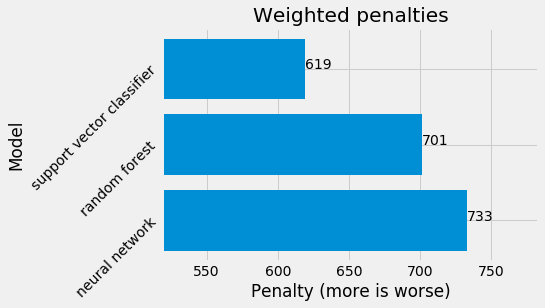

In [122]:
def plotScores(scores,modelNames):
    fig, ax = plt.subplots()

    ax.barh(modelNames, scores, align='center')
    ax.set_xlabel('Penalty (more is worse)')
    ax.set_ylabel('Model')
    ax.set_title('Weighted penalties')
    ax.set_xlim(min(scores)-100,max(scores)+50)
    for tick in ax.get_yticklabels():
            tick.set_rotation(45)

    for i, score in enumerate(scores):
        ax.text(score, i, "%d"%score)
    plt.show()
plotScores(scores[1:],modelNames[1:])

Using this more adequate metric, we see once again that the random forest and neural network are performing similarly, while the support vector classifier is behaving better than both of them. 

In conclusion, all three methods don't suffer much from over-fitting, however both random forest and neural network seem to be quite negatively affected by the imbalance in the size of the three classes more than SVC. As mentioned in the discussion after the training of the differently sized neural networks, given the scenario computational cost is probably a negligible factor when choosing between the methods; if it were to be taken into consideration, it would be negligible for SVM and random forest, thus penalising neural network. Overall the most suitable method would be that of support vector classification.

Could this have been predicted beforehand? Neural networks have been tuned for dealing with highly dimensional data like image recognition, in which every pixel can be thought of as representing a dimension in our data. In our case we only have 6 dimensions which means that we are unable to use the full power of the network. In general SVMs tend to perform better than random forests on two class problems, while random forests tend to do better on multiclass, however our classes are ordered and the number of classes at 4 is quite low, meaning that SVM will still be a better method.

Actually, given the low dimensionality, and that each predictor has only a few possible values, there are only a couple thousand possible combinations. This means that while tedious, it would in principle be possible to manually compile the list of all possible scores in each cathegory and then decide for each a score. In this sort of task human intuition might actually prove better than computers at predicting the value of a certain car.

While usually both ranodm forests and SVMs perform terribly with cathegorical data, needing one-hot-encoding, which increases the sparsity and dimensionality of the data, we have avoided the problem by using the natural order which our data has and basically treating it as though it were continuous.

One more aspect which we haven't discussed is that both neural network and random forests output the probability of belonging to each class, this could be used to output a predicted rating for each car. As the ratings are ordered, this might actually might give a better prediction tool than just blunt classification, meaning that random forest and neural network might actually predict better once this has been taken into consideration (SVMs also have a way to output probabilities, by looking at distance from the boundary, but this is less straight forward and in some cases the output won't be close to what we intend by probability). 

# Task 5
Given our object-oriented approach, implementing the deep neural network, only requires us to specify the new structure, without having to worry about re-implementing the code for training. To use a sigmoidal neural network we will only have to specify it as a parameter. Note that we will treat tasks 5.1 and 5.2 jointly. 

In [148]:
class NNDeep(NNBase):
    def __init__(self, learningRate=1e-2, batchSize=64, verbose=True, validate=True, dropoutChance = 0):
        super(NNDeep, self).__init__(learningRate, batchSize, verbose, validate)
        self.layerIn = nn.Linear(N_PREDICTORS, 80)
        self.layerHidden = nn.Linear(80, 80)
        self.layerOut = nn.Linear(80, N_RATINGS)
        self.relu = nn.ReLU()
        self.dropoutLayer = nn.Dropout(p = dropoutChance)
    
    def forward(self, x):
        out = self.layerIn(x)
        out = self.relu(out)
        out = self.dropoutLayer(out)
        out = self.layerHidden(out)
        out = self.relu(out)
        out = self.layerHidden(out)
        out = self.relu(out)
        out = self.layerHidden(out)
        out = self.relu(out)
        out = self.layerHidden(out)
        out = self.relu(out)
        out = self.layerOut(out)
        return out

Since there are only three neural networks that require training, we can increase the number of epochs we use in training to get a better glimpse at the long-term behaviour of the different models.

In [149]:
N_EPOCHS = 240
networkBase = NNShallow(dropoutChance=bestDropout)

if useCuda:
    networkBase.cuda()
start = datetime.now()
lossBase,lossBaseVal = networkBase.fit(X,y) #train network using X as predictor and y as labels
timeBase = (datetime.now() - start)/norm

Epoch [240/240]

In [150]:
networkDeep = NNDeep(dropoutChance=bestDropout)
if useCuda:
    networkDeep.cuda()

start = datetime.now()
lossDeep, lossValDeep = networkDeep.fit(X,y)
timeDeep = (datetime.now() - start)/norm

Epoch [240/240]

In [151]:
networkSigmoid = NNShallow(activationFun=nn.Sigmoid(),dropoutChance=bestDropout)
if useCuda:
    networkSigmoid.cuda()

start = datetime.now()
lossSigmoid, lossSigmoidVal = networkSigmoid.fit(X,y)
timeSigmoid = (datetime.now() - start)/norm

Epoch [240/240]

We now plot the validation and training loss, as well as the classification report and the confusion matrix.

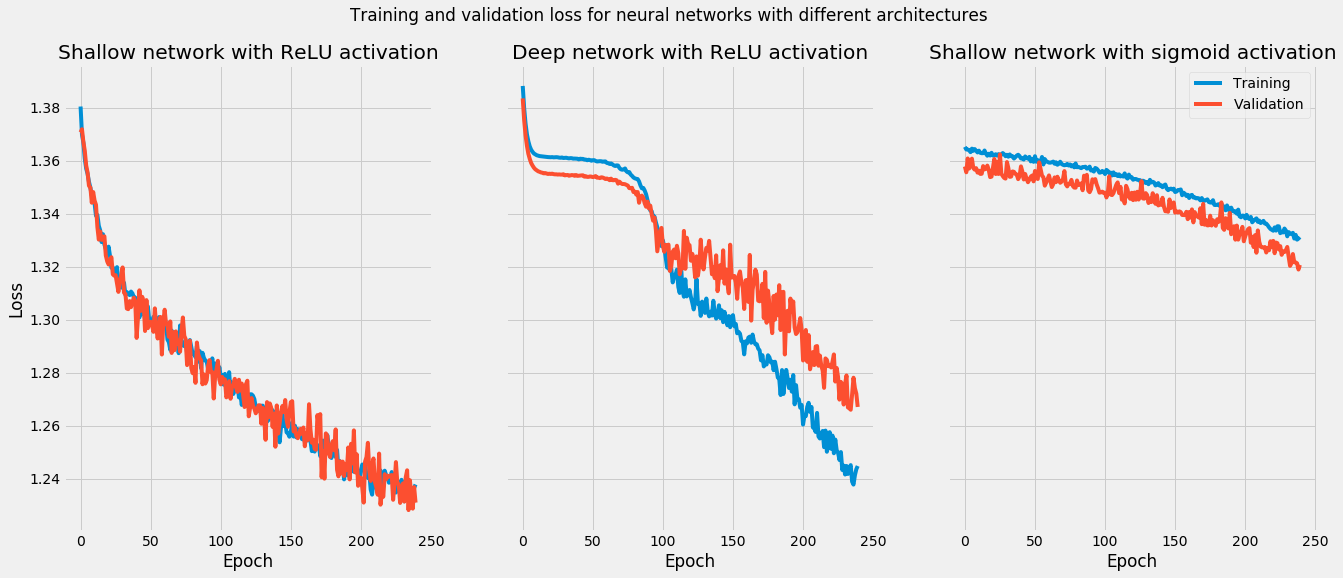

In [152]:
fig, axes = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(20,8)
fig.suptitle("Training and validation loss for neural networks with different architectures")

axes[0].plot(lossBase)
axes[0].plot(lossBaseVal)
axes[0].set_ylabel("Loss")
axes[0].set_title("Shallow network with ReLU activation")

axes[1].plot(lossDeep)
axes[1].plot(lossValDeep)
axes[1].set_title("Deep network with ReLU activation")

axes[2].plot(lossSigmoid,label="Training")
axes[2].plot(lossSigmoidVal,label="Validation")
axes[2].set_title("Shallow network with sigmoid activation")
axes[2].legend()

for ax in axes:
    ax.set_xlabel("Epoch")
plt.show()

In [153]:
models = [dummy, networkBase, networkDeep, networkSigmoid]
modelNames = ["dummy", "basic neural network", "deep neural network", "sigmoid neural network"]

reports = [None]*4
confusionMatrices = [None]*4
for i, name in enumerate(modelNames):
    reports[i], confusionMatrices[i] = getReport(XTest,yTest,models[i],name)
for report in reports:
    print(report+"\n-------------------------\n")

Classification report for model: dummy
              precision    recall  f1-score   support

       unacc       0.42      1.00      0.59       412
         acc       0.00      0.00      0.00       188
        good       0.00      0.00      0.00       204
       vgood       0.00      0.00      0.00       188

    accuracy                           0.42       992
   macro avg       0.10      0.25      0.15       992
weighted avg       0.17      0.42      0.24       992

-------------------------

Classification report for model: basic neural network
              precision    recall  f1-score   support

       unacc       0.62      0.83      0.71       412
         acc       0.38      0.16      0.23       188
        good       0.46      0.33      0.39       204
       vgood       0.50      0.58      0.54       188

    accuracy                           0.55       992
   macro avg       0.49      0.48      0.46       992
weighted avg       0.52      0.55      0.52       992

----------

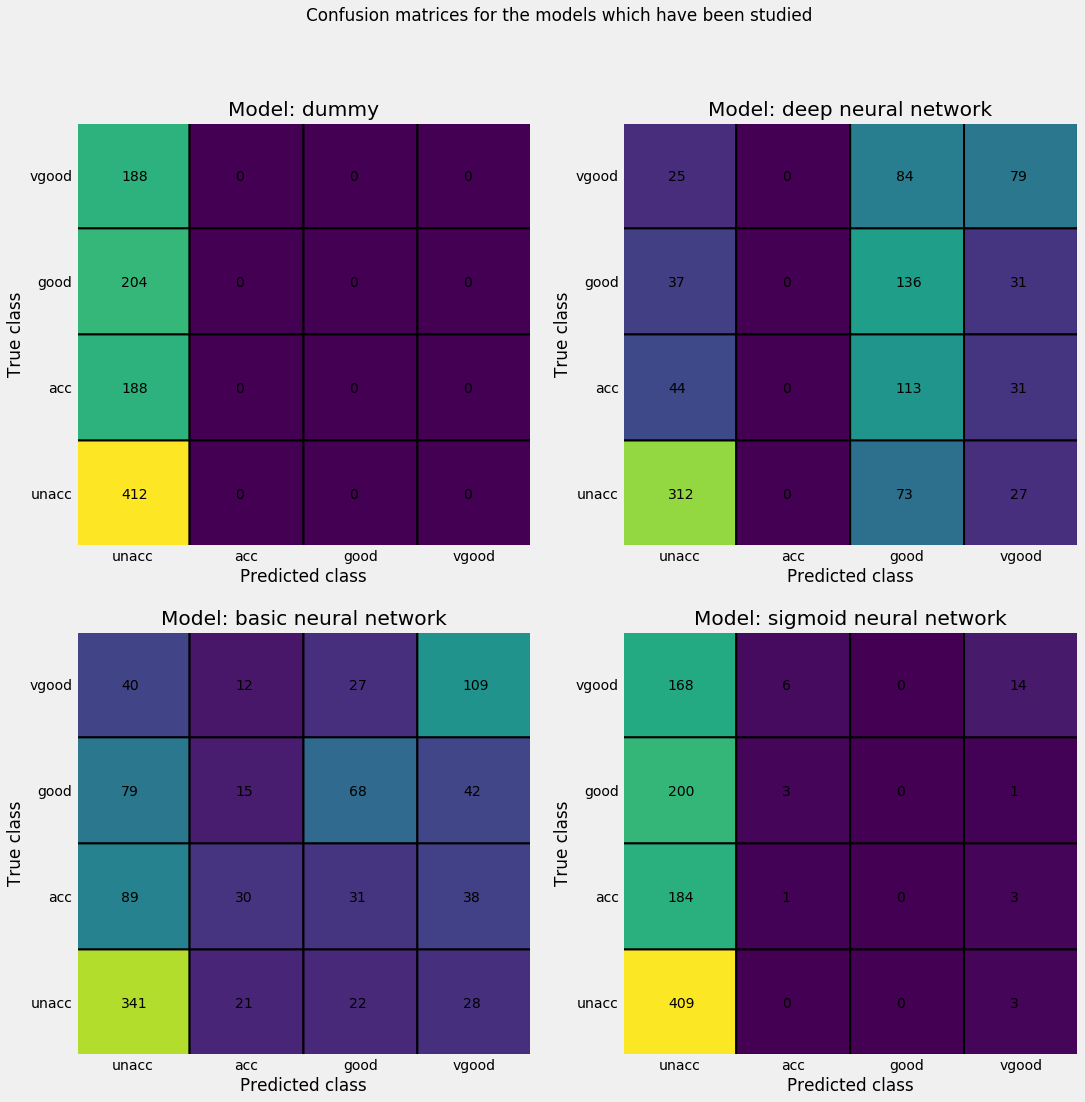

In [154]:
plotConfusionMatrix(confusionMatrices, modelNames)

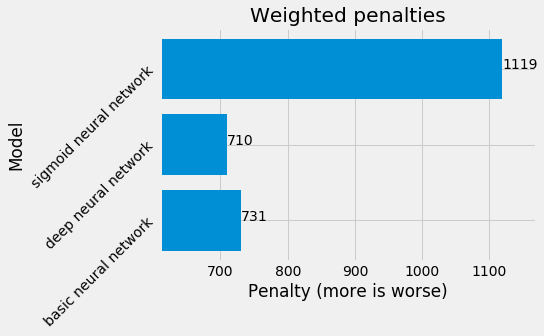

In [155]:
scores = [getScore(mat) for mat in confusionMatrices]
plotScores(scores[1:], modelNames[1:])

Note that there is quite a bit of variation in the results for deep networks and sigmoid activated ones across different runs. This can be explained by them getting stuck at a local minimum, how long it takes them to start moving towards the global minimum, and which local minimum they reach seems to vary quite a lot across different runs. In this case we see the basic neural network behaving much like before, suggesting that the extra training time hasn't been useful, in other words it has exhausted its predictive power. The sigmoidal neural network in general only slightly deviates from the dummy classifier strategy: in none of the runs I checked did it predict more than three different classes, in most cases labeling almost all cars as the plurality class. The deep neural network does seem to do a much better job, but clearly it would benefit from more training time. It sometimes also completely ignores one of the classes, however this isn't necessarily because of a dummy-like behaviour: in some cases it will seemingly have a preference for one of the middle classes. This helps it in the weighted penalty, sometimes beeting out the basic neural network.

The deep neural network's loss on both validation and training data seems to plateau consistently from around epoch 10 to epoch 100. What is probably happening is that it is getting stuck at a dummy-like strategy, from which it is hard to escape. It takes a while for it to notice different, more interesting patterns in the data.

In [156]:
print("Computation time for\nShallow neural network:\t%.1f\nDeep neural network: \t%.1f"%(timeBase,timeDeep))

Computation time for
Shallow neural network:	51.9
Deep neural network: 	71.1


The literature \[2,3\] seems to be pretty consistent in declaring that deep neural networks manage better performance than shallow ones given the same computation time and number of parameters. However as can be seen above the computation time is longer for the deep network, and the usual metric used for evaluating performance (accuracy) favours the shallow one. To explain this discrepancy we must look carefully at the types of problem the literature is referring to. This is mostly related to the problems most commonly associated with neural networks like image and voice recognition. Both of them are highly dimensional problems with huge amounts of data, very distinct from our classifcation task. Furthermore, shallow networks are defined as networks with a single hidden layer, this is as opposed to our architecture which has two hidden layers. And in any case the numbers of epochs we use for training, 240, might be too low to mimic the asymptotic behaviour described in the papers. It might well be the case that after sufficiently many epochs the shallow network reaches the limits of its predictive capabilities with the deep network still being able to notice new interesting features.

[2]: Ba, J. and Caruana, R., 2014. _Do deep nets really need to be deep?_. In Advances in neural information processing systems (pp. 2654-2662).

[3]: Liang, S. and Srikant, R., 2016. _Why deep neural networks for function approximation?_. arXiv preprint arXiv:1610.04161.